In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mini_yolov3.model import YOLO
from mini_yolov3.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov3.loss import YOLOLoss, build_target
import matplotlib.pyplot as plt
from mini_yolov3.utils import draw_bounding_boxes, count_model_parameters, draw_grid
from torchvision.ops import box_convert
from mini_yolov3.evals import calculate_mAP
from torchvision.ops import box_iou
from tqdm import tqdm

/Users/ericchen/Library/Caches/pypoetry/virtualenvs/mini-yolov3-a3VRlvzj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_dataset = SVHNDataset(split="train", image_size=64)
# train_dataset = Subset(train_dataset, range(12, 13))

In [4]:
train_dataset[0]["bbox"]

tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])

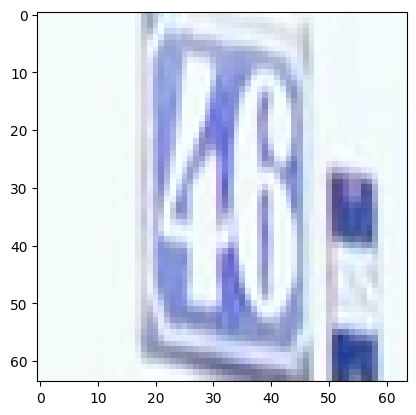

In [5]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

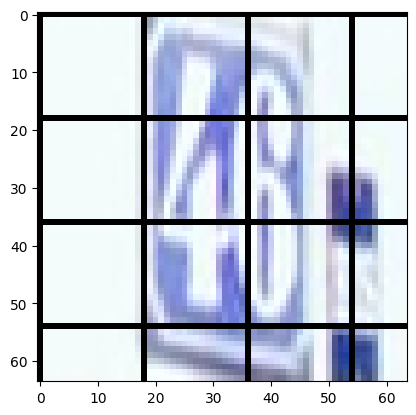

In [6]:
plt.imshow(draw_grid(train_dataset[0]["image"], 128//7))

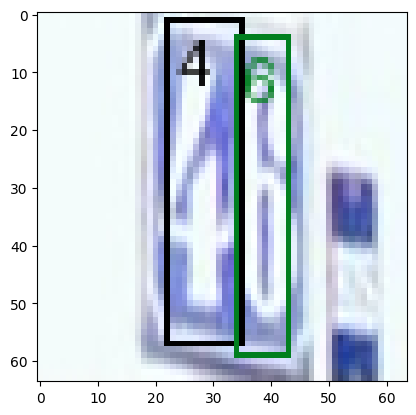

In [7]:
plt.imshow(
    draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["labels"])
)

In [8]:
train_dataset_ = Subset(train_dataset, range(0, 2))

In [9]:
import json

In [12]:
torch.manual_seed(0)

config = json.load(open("./configs/experiment.json", "r"))
model = YOLO(**config)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset_,
    num_epochs=100,
    lr=1e-3,
    batch_size=32,
    log_detections=False,
    lambda_coord=5.0,
    lambda_noobj=0.5,
    device="cpu",
    eval_every=100000,
)

100%|██████████| 100/100 [00:22<00:00,  4.40it/s, class_loss=2.05e-5, coord_loss=3.91e-5, loss=0.000128, noobj_loss=5.1e-5, obj_conf_loss=1.69e-5]    


[2.879676103591919,
 5.6004319190979,
 3.2647929191589355,
 0.9908711314201355,
 2.4831182956695557,
 0.35594674944877625,
 0.5406615734100342,
 0.5166249871253967,
 0.536304235458374,
 0.7394300103187561,
 0.6050507426261902,
 0.6425511240959167,
 0.6317963004112244,
 0.5293169021606445,
 0.4345596730709076,
 0.3146669864654541,
 0.2910960614681244,
 0.2545556426048279,
 0.26281121373176575,
 0.25739845633506775,
 0.31239423155784607,
 0.3249179422855377,
 0.3098657727241516,
 0.2773897349834442,
 0.21181078255176544,
 0.14283587038516998,
 0.35468780994415283,
 0.09213727712631226,
 0.09291478991508484,
 0.10579587519168854,
 0.11111906170845032,
 0.09925217926502228,
 0.07441769540309906,
 0.058738090097904205,
 0.062330082058906555,
 0.0528549998998642,
 0.051993802189826965,
 0.052269041538238525,
 0.05244751274585724,
 0.04485782980918884,
 0.03229759633541107,
 0.026530064642429352,
 0.024987421929836273,
 0.020571956411004066,
 0.01707618311047554,
 0.017514504492282867,
 0.018

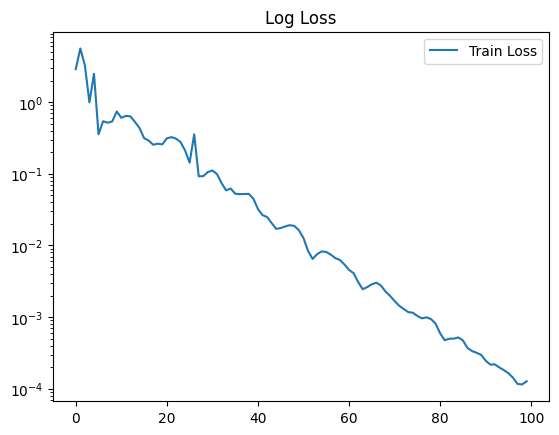

In [13]:
trainer.train()

In [188]:
count_model_parameters(model)

1998692

In [189]:
dataloader = DataLoader(train_dataset_, batch_size=10, shuffle=False, collate_fn=collate_fn)
batch = next(iter(dataloader))

In [190]:
batch

{'images': tensor([[[[0.9569, 0.9529, 0.9490,  ..., 0.9569, 0.9569, 0.9529],
           [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529],
           [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529],
           ...,
           [0.9529, 0.9569, 0.9529,  ..., 0.9451, 0.9490, 0.9529],
           [0.9608, 0.9608, 0.9608,  ..., 0.9451, 0.9490, 0.9529],
           [0.9647, 0.9608, 0.9647,  ..., 0.9451, 0.9529, 0.9569]],
 
          [[0.9922, 0.9882, 0.9843,  ..., 0.9882, 0.9882, 0.9843],
           [0.9882, 0.9882, 0.9882,  ..., 0.9843, 0.9843, 0.9843],
           [0.9882, 0.9882, 0.9882,  ..., 0.9843, 0.9843, 0.9843],
           ...,
           [0.9843, 0.9882, 0.9843,  ..., 0.9804, 0.9843, 0.9804],
           [0.9804, 0.9843, 0.9843,  ..., 0.9765, 0.9804, 0.9804],
           [0.9804, 0.9804, 0.9843,  ..., 0.9725, 0.9765, 0.9765]],
 
          [[0.9882, 0.9843, 0.9804,  ..., 0.9961, 0.9961, 0.9922],
           [0.9843, 0.9843, 0.9843,  ..., 0.9922, 0.9922, 0.9922],
           [0.

In [191]:
i = 1

In [192]:
output = model.inference(
    batch["images"],
    confidence_threshold=0.5,
)

bounding_boxes = output.bboxes
bounding_boxes

[{'bboxes': tensor([[0.4534, 0.4566, 0.1964, 0.8689],
          [0.6074, 0.5002, 0.1501, 0.8688]]),
  'confidence': tensor([1.0000, 0.9904]),
  'labels': tensor([4, 6]),
  'scores': tensor([0.9940, 0.9998])},
 {'bboxes': tensor([[0.5930, 0.5838, 0.1475, 0.6573],
          [0.4426, 0.5004, 0.1963, 0.7406]]),
  'confidence': tensor([1.0000, 0.9987]),
  'labels': tensor([1, 7]),
  'scores': tensor([0.9963, 1.0000])}]

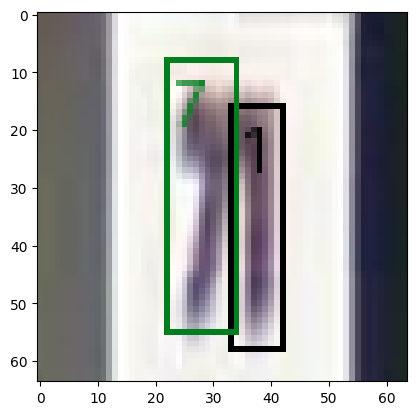

In [193]:
plt.imshow(
    draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
)
)

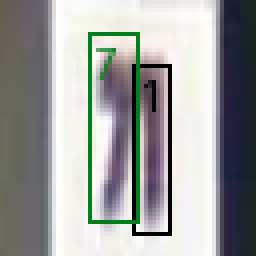

In [194]:
draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
).resize((256, 256), 0)

In [195]:
calculate_mAP(
    model,
    trainer.train_loader,
)

{'map': 0.800000011920929,
 'map_50': 1.0,
 'map_75': 0.75,
 'map_small': 0.800000011920929,
 'map_medium': -1.0,
 'map_large': -1.0,
 'mar_1': 0.800000011920929,
 'mar_10': 0.800000011920929,
 'mar_100': 0.800000011920929,
 'mar_small': 0.800000011920929,
 'mar_medium': -1.0,
 'mar_large': -1.0,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0,
 'classes': [1, 4, 6, 7]}

In [325]:
torch.distributed.is_available()

True

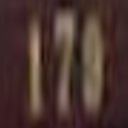

In [165]:
from PIL import Image
from torchvision.transforms import v2
image_path = "./examples/image (6).jpg"

G = 256
image = Image.open(image_path).resize((G, G))
image = v2.CenterCrop(128)(image)
image

In [169]:
G = 64

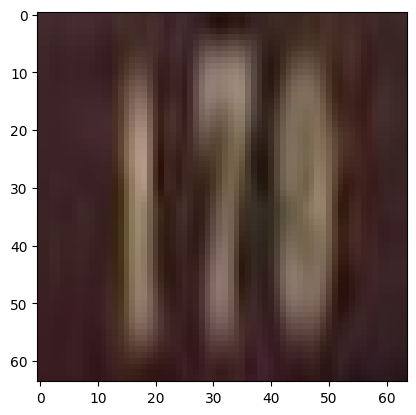

In [170]:
plt.imshow(image.resize((G, G), Image.LANCZOS))

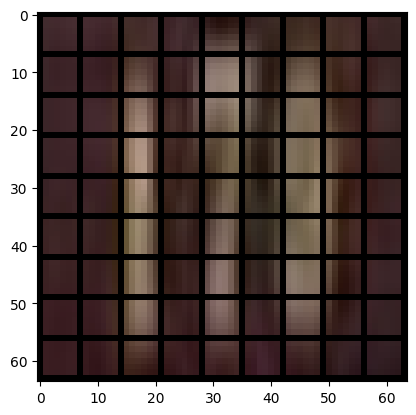

In [171]:
plt.imshow(draw_grid(image.resize((G, G)), G//9))

In [64]:
image.size

(76, 34)